In [1]:
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from roboflow import Roboflow
import ast
import boto3
import botocore
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import pathlib
import random
import shutil
import time
import torch
import torchvision.transforms as transforms
import yaml

# Load environment variables from .env file
load_dotenv("../.env")

True

In [2]:
base_path = os.environ["DATASET_BASE_PATH_EXPLORE"]
try:
    shutil.rmtree(base_path)
except:
    pass
os.mkdir(base_path)

In [3]:
s3 = boto3.resource('s3')
BUCKET = "sjsu-fall24-data298-team6-bucket"
KEY = 'dataset/yolo.zip' # download whichever dataset format you need
try:
    s3.Bucket(BUCKET).download_file(KEY, f'{base_path}/data.zip')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise


In [4]:
!unzip -q $DATASET_BASE_PATH_EXPLORE/data.zip -d $DATASET_BASE_PATH_EXPLORE/data

# VisDrone Dataset

In [5]:
base_path = Path(base_path) / "data"
with open(base_path / "data.yaml", "r") as f:
    yaml_file = yaml.safe_load(f)

In [6]:
print(yaml_file)

{'names': ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor'], 'nc': 10, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}


In [7]:
classes = yaml_file["names"]
print("Classes in dataset:", classes)
print("Number of classes in dataset: ", len(classes))
print("Number of training images: ", len(os.listdir(base_path / "train/images")))
print("Number of testing images: ", len(os.listdir(base_path / "test/images")))
print("Number of validation images: ", len(os.listdir(base_path / "valid/images")))

Classes in dataset: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']
Number of classes in dataset:  10
Number of training images:  5176
Number of testing images:  648
Number of validation images:  647


In [8]:
def class_counts_per_split(split):
    split_path = base_path / split / "labels"
    class_counts = {}
    for label in os.listdir(split_path):
        with open(split_path / label, "r") as f:
            lines = f.read().splitlines()
        for line in lines:
            class_id = line.split()[0]
            class_id = int(class_id)
            try:
                class_counts[class_id] += 1
            except:
                class_counts[class_id] = 1

    class_count_with_name = {}
    print(f"{split} split")
    print("Class name           | count")
    print("----------------------------")
    for i, c in enumerate(classes):
        try:
            count = class_counts[i]
        except:
            count = 0
        print(f"{c:<20} | {count}")
        class_count_with_name[c] = count
    return class_count_with_name

In [9]:
train_count = class_counts_per_split("train")

train split
Class name           | count
----------------------------
pedestrian           | 63486
people               | 21941
bicycle              | 8471
car                  | 116144
van                  | 19858
truck                | 10378
tricycle             | 3890
awning-tricycle      | 2660
bus                  | 4893
motor                | 24180


In [10]:
test_count = class_counts_per_split("test")

test split
Class name           | count
----------------------------
pedestrian           | 7712
people               | 2495
bicycle              | 1108
car                  | 14486
van                  | 2530
truck                | 1188
tricycle             | 458
awning-tricycle      | 256
bus                  | 552
motor                | 2657


In [11]:
valid_count = class_counts_per_split("valid")

valid split
Class name           | count
----------------------------
pedestrian           | 8139
people               | 2623
bicycle              | 901
car                  | 14237
van                  | 2568
truck                | 1309
tricycle             | 464
awning-tricycle      | 330
bus                  | 481
motor                | 2810


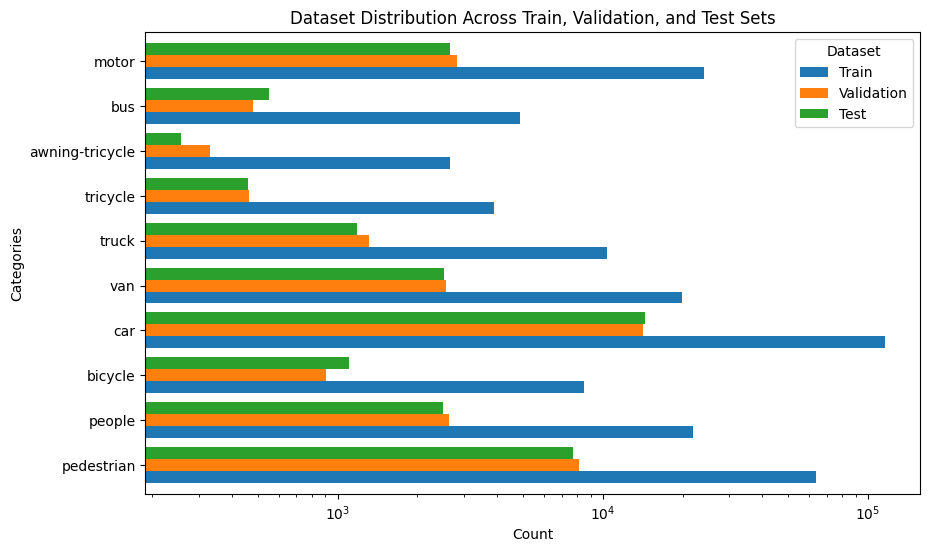

In [12]:
# Create a DataFrame
data = {"Train": train_count, "Validation": valid_count, "Test": test_count}
df = pd.DataFrame(data)

# Plotting
df.plot(kind="barh", figsize=(10, 6), width=0.8)

# Labels and title
plt.xlabel("Count")
plt.ylabel("Categories")
plt.title("Dataset Distribution Across Train, Validation, and Test Sets")
plt.xscale("log")
plt.legend(title="Dataset")

plt.show()

In [13]:
img_sizes = []
bbx_sizes = []
num_label = []
for split in ["train", "valid", "test"]:
    split_path = base_path / split / "labels"
    for label in os.listdir(split_path):
        label_file = split_path / label
        image_file = Path(label_file.parent.parent / "images" / label_file.parts[-1]).with_suffix(".jpg")
        img = Image.open(image_file)
        imgw, imgh = img.size
        with open(label_file, "r") as f:
            lines = f.read().splitlines()
        x = 0
        for line in lines:
            _,_,w,h = line.split()[1:]
            w = int(float(w) * imgw) + 1
            h = int(float(h) * imgh) + 1
            bbx_sizes.append(w * h)
            x += 1
        num_label.append(x)
        img_sizes.append(imgw * imgh)

In [14]:
avg_img = sum(img_sizes) / len(img_sizes)
avg_bbx = sum(bbx_sizes) / len(bbx_sizes)
avg_num = sum(num_label) / len(num_label)

max_img_size = max(img_sizes)
min_img_size = min(img_sizes)
max_bbx_size = max(bbx_sizes)
min_bbx_size = min(bbx_sizes)

print(f"{'Average Image Area:':<45}{avg_img:.6f} px^2")
print(f"{'Average Bounding Box Area:':<45}{avg_bbx:.6f} px^2")
print(f"{'Ratio of Bounding Box Area to Image Area:':<45}{avg_bbx / avg_img * 100:.6f}%")
print(f"{'Average Number of Classifications per Image:':<45}{int(avg_num)}")
print("\nImage Sizes:")
print(f" - Max: {max_img_size}")
print(f" - Min: {min_img_size}")
print("\nBounding Box Sizes:")
print(f" - Max: {max_bbx_size}")
print(f" - Min: {min_bbx_size}")

Average Image Area:                          1573546.484006 px^2
Average Bounding Box Area:                   2493.606550 px^2
Ratio of Bounding Box Area to Image Area:    0.158470%
Average Number of Classifications per Image: 53

Image Sizes:
 - Max: 3000000
 - Min: 172800

Bounding Box Sizes:
 - Max: 329847
 - Min: 4


In [15]:
font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
fz = 36
font = ImageFont.truetype(font_path, size=fz)

def xywh2xyxy(x,y,w,h):
    xl = x - w/2
    xr = x + w/2
    yt = y - h/2
    yb = y + h/2
    return xl, yt, xr, yb

def display_image_with_bbox(img_path, label_path, title=None):
    img = Image.open(img_path)
    imgw, imgh = img.size
    with open(label_path, "r") as f:
        labels = f.read().splitlines()
    for label in labels:
        c,x,y,w,h = label.split()
        c = int(c)
        class_name = yaml_file["names"][c]
        x = float(x) * imgw
        y = float(y) * imgh
        w = float(w) * imgw
        h = float(h) * imgh
        bbox = xywh2xyxy(x,y,w,h)
        bbox_img = ImageDraw.Draw(img)
        bbox_img.rectangle(bbox, outline="green", fill=None, width=5)
        ImageDraw.Draw(img).text((bbox[0]-fz, bbox[1]-fz), class_name, font=font)
    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()

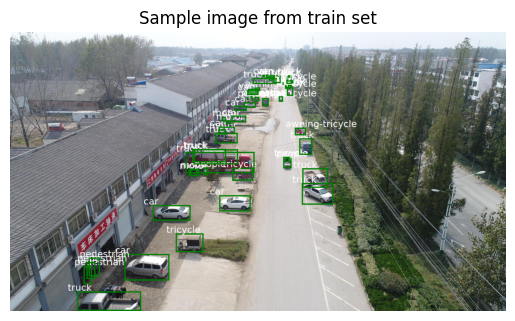

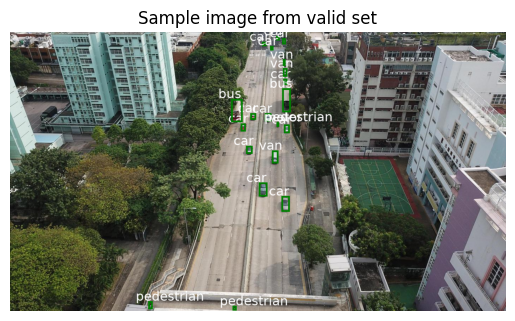

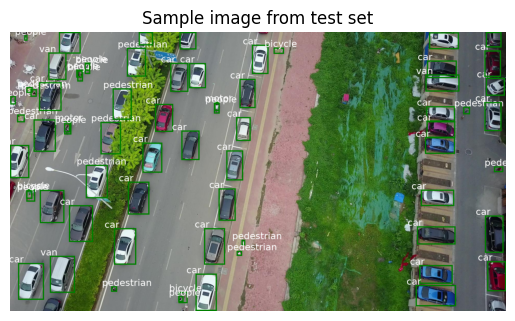

In [16]:
for split in ["train", "valid", "test"]:
    split_path = base_path / split / "labels"
    label = random.choice(os.listdir(split_path))
    label_file = split_path / label
    image_file = Path(label_file.parent.parent / "images" / label_file.parts[-1]).with_suffix(".jpg")
    display_image_with_bbox(image_file, label_file, f"Sample image from {split} set")